
# PCA and Classification on Synthetic Financial Data: Extended Analysis

This notebook demonstrates an extended analysis on a synthetic financial dataset. We apply Principal Component Analysis (PCA) to reduce dimensionality, perform exploratory data analysis, and build a classification model to detect distressed firms. The notebook covers:
- Data exploration and correlation analysis
- PCA computation and detailed explained variance analysis
- Visualization of principal components and loadings
- Building and evaluating a Logistic Regression classifier with cross-validation and ROC analysis


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Simulate dataset for 500 firms with 8 financial indicators
n_firms = 500
data = {
    'ROE': np.random.normal(10, 3, n_firms),              # Return on Equity
    'ROA': np.random.normal(5, 2, n_firms),               # Return on Assets
    'Capital_Adequacy': np.random.normal(12, 4, n_firms), # Capital Adequacy Ratio
    'NPL_ratio': np.random.normal(6, 2, n_firms),         # Non-Performing Loans ratio
    'Cost_Income_Ratio': np.random.normal(60, 10, n_firms), # Cost/Income Ratio
    'Loan_Growth': np.random.normal(8, 5, n_firms),       # Loan Growth
    'Liquidity_Ratio': np.random.normal(25, 7, n_firms),  # Liquidity Ratio
    'Leverage': np.random.normal(15, 5, n_firms)          # Financial Leverage
}

# Create a binary target for financial distress.
# Firms with low ROE and high NPL_ratio are marked as distressed.
data['Distressed'] = ((data['ROE'] < 8) & (data['NPL_ratio'] > 6)).astype(int)

# Create DataFrame
df = pd.DataFrame(data)
print("First 5 rows of the dataset:")
display(df.head())

print("Dataset summary:")
display(df.describe())


First 5 rows of the dataset:


,ROE,ROA,Capital_Adequacy,NPL_ratio,Cost_Income_Ratio,Loan_Growth,Liquidity_Ratio,Leverage,Distressed
0,11.490142,6.852355,17.597422,7.556722,53.248217,10.853065,11.645347,20.903205,0
1,9.585207,8.818833,15.698535,4.897629,58.554813,12.840923,18.977305,11.863433,0
2,11.943066,2.202865,12.238521,4.363602,52.075801,6.343458,22.104761,15.226114,0
3,14.569090,6.125938,9.412253,5.993251,56.920385,4.938816,38.213814,15.255990,0
4,9.297540,3.698715,14.792893,5.659631,41.063853,2.574247,28.895872,12.491079,0


Dataset summary:


,ROE,ROA,Capital_Adequacy,NPL_ratio,Cost_Income_Ratio,Loan_Growth,Liquidity_Ratio,Leverage,Distressed
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,10.020514,5.063652,12.433938,6.066376,59.884836,8.115924,24.870316,14.905440,0.11400
std,2.943760,1.955994,4.040985,1.968132,9.595662,5.037193,7.268725,5.083956,0.31813
min,0.276198,-0.393773,0.414978,0.119223,29.804878,-6.955680,4.493859,2.533646,0.00000
25%,7.899078,3.809417,9.590282,4.776128,53.392636,4.864238,19.868553,11.212506,0.00000
50%,10.038391,5.057063,12.479223,5.982173,59.968477,8.017678,24.860089,15.037647,0.00000
75%,11.910350,6.302485,15.018953,7.399539,66.691764,11.161336,29.866770,18.016756,0.00000
max,21.558194,10.264764,22.406732,12.386215,91.099186,27.631189,45.078821,31.215465,1.00000



## Exploratory Data Analysis: Correlation Matrix

Below is the correlation matrix of the financial indicators to understand relationships between variables.


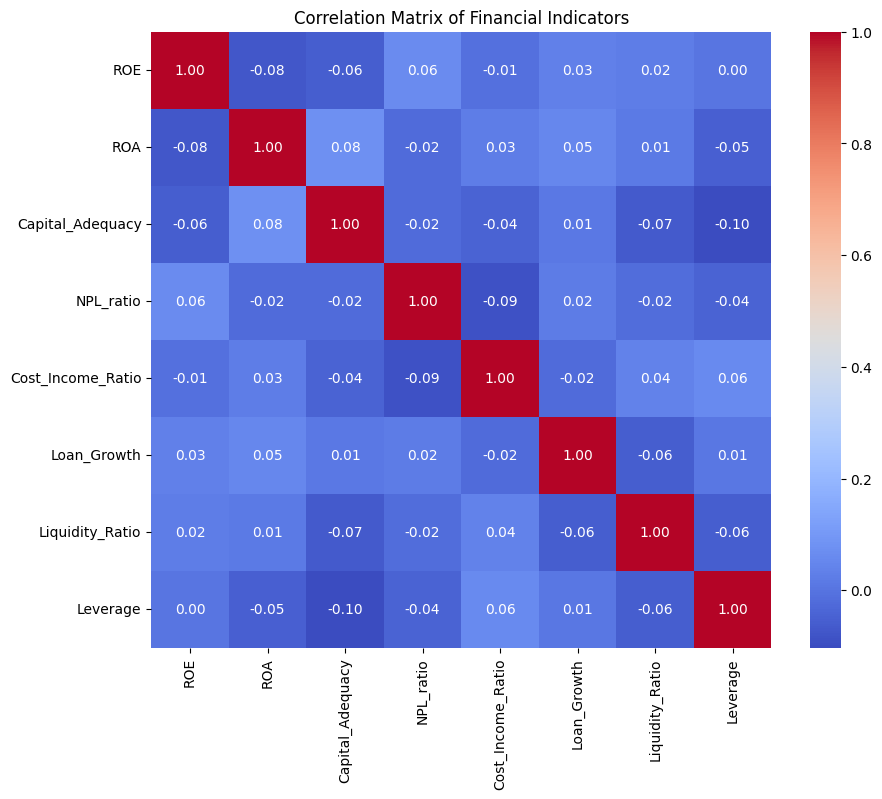

In [ ]:

# Compute correlation matrix for features (excluding target)
corr_matrix = df.drop(columns='Distressed').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Financial Indicators")
plt.show()



## Data Standardization

Standardizing the features is crucial before applying PCA.


In [ ]:

from sklearn.preprocessing import StandardScaler

# Separate features and target
features = df.drop(columns='Distressed')
target = df['Distressed']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
print("Mean of standardized features (should be ~0):", X_scaled.mean(axis=0))
print("Standard deviation of standardized features (should be 1):", X_scaled.std(axis=0))


Mean of standardized features (should be ~0): [ 1.77635684e-17 -2.70006240e-16  1.24344979e-16  6.03961325e-16
  1.42108547e-17 -2.84217094e-17 -2.91322522e-16 -1.06581410e-16]
Standard deviation of standardized features (should be 1): [1. 1. 1. 1. 1. 1. 1. 1.]



## PCA Computation

We apply PCA on the standardized features and inspect the explained variance.


In [ ]:

# Apply PCA without limiting components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(data=X_pca, columns=pca_columns)
pca_df['Distressed'] = target

# Explained variance ratio
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
for i, var in enumerate(explained_var):
    print(f"PC{i+1}: {var:.4f}")


Explained variance ratio for each principal component:
PC1: 0.1505
PC2: 0.1448
PC3: 0.1355
PC4: 0.1268
PC5: 0.1177
PC6: 0.1134
PC7: 0.1079
PC8: 0.1035



## Scree Plot and Cumulative Explained Variance

The scree plot visualizes the amount of variance explained by each principal component.


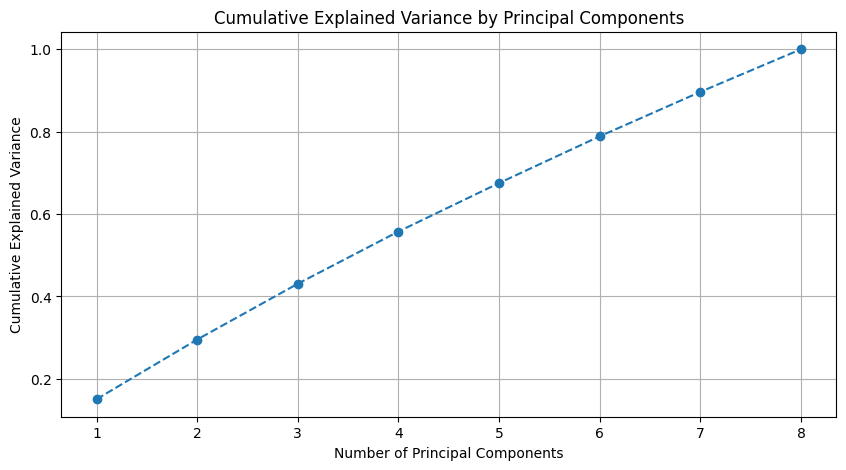

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_var)+1))
plt.grid(True)
plt.show()



## Explained Variance of Each Component

This bar plot shows the explained variance for each principal component.


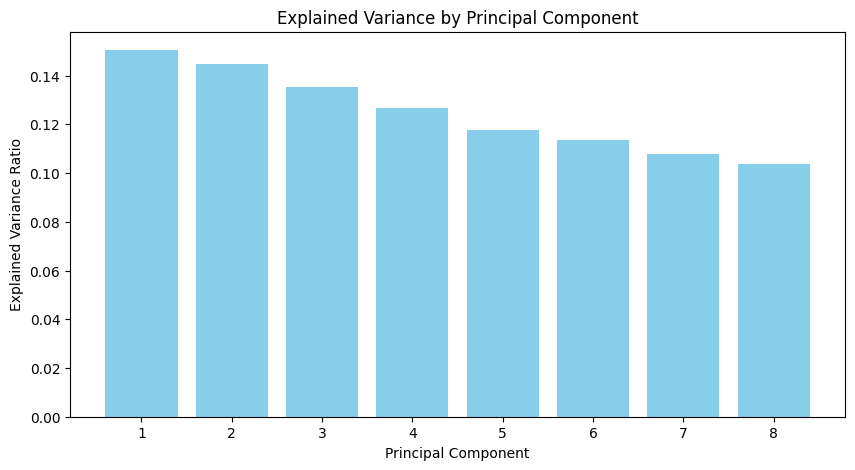

In [ ]:

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var)+1), explained_var, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, len(explained_var)+1))
plt.show()



## Biplot: PC1 vs PC2

The biplot visualizes the projection of firms on the first two principal components, colored by their distress status.


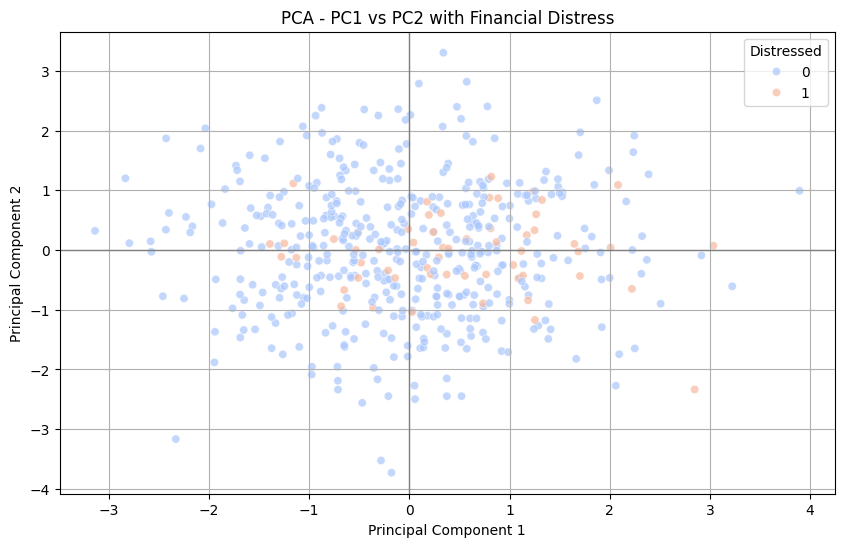

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Distressed', data=pca_df, palette='coolwarm', alpha=0.7)
plt.title('PCA - PC1 vs PC2 with Financial Distress')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.legend(title='Distressed')
plt.grid(True)
plt.show()



## PCA Loadings

The heatmap below shows the contribution (loadings) of each original feature to the principal components.


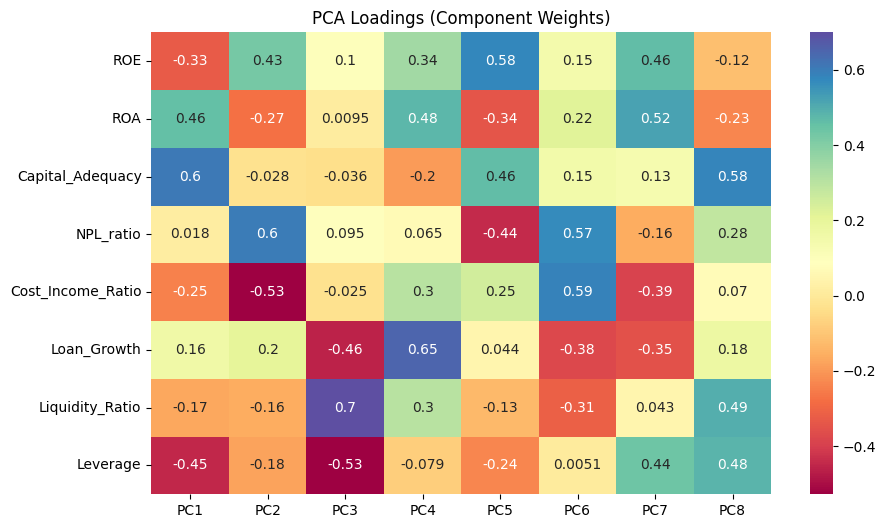

In [ ]:

# Calculate loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=pca_columns,
                        index=features.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='Spectral')
plt.title('PCA Loadings (Component Weights)')
plt.show()



## Detailed Loadings for PC1 and PC2

Below, we plot bar charts to visualize the contribution of each feature to PC1 and PC2.


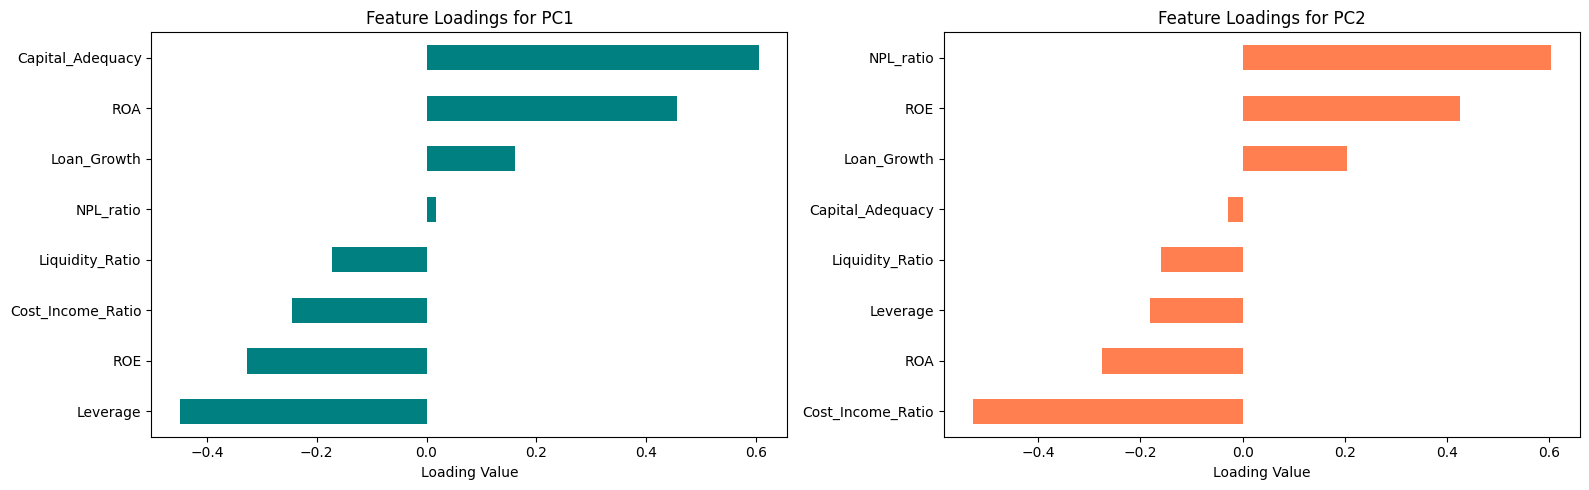

In [ ]:

# Loadings for PC1 and PC2
loadings_pc1 = loadings['PC1']
loadings_pc2 = loadings['PC2']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
loadings_pc1.sort_values().plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title('Feature Loadings for PC1')
axes[0].set_xlabel('Loading Value')

loadings_pc2.sort_values().plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Feature Loadings for PC2')
axes[1].set_xlabel('Loading Value')

plt.tight_layout()
plt.show()



## Classification Model: Logistic Regression

We build a logistic regression classifier using the top principal components that explain ~90% of the variance.


In [ ]:

# Determine number of components that explain at least 90% of variance
cumulative_variance = np.cumsum(explained_var)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of principal components to retain for 90% variance: {n_components_90}")

# Use selected principal components
X_pca_selected = X_pca[:, :n_components_90]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, target, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Number of principal components to retain for 90% variance: 8
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       134
           1       1.00      0.62      0.77        16

    accuracy                           0.96       150
   macro avg       0.98      0.81      0.87       150
weighted avg       0.96      0.96      0.96       150




## Confusion Matrix

The confusion matrix provides insights into classification performance.


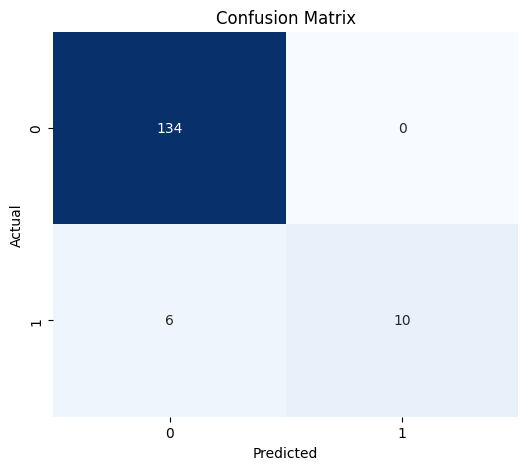

In [ ]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



## ROC Curve Analysis

We plot the ROC curve and calculate the AUC to evaluate the classifier's performance.


AUC: 0.9743


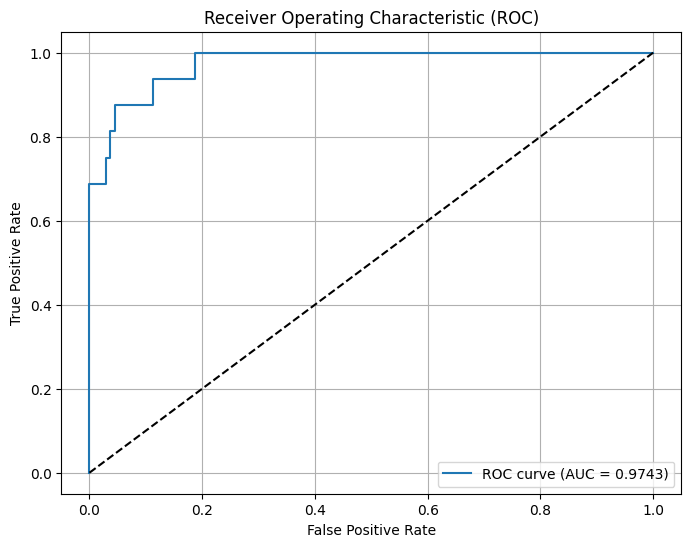

In [ ]:

# Compute probabilities for the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



## Cross-Validation

We perform cross-validation to assess the stability of our classification model.


In [ ]:

# Perform 5-fold cross-validation on the logistic regression classifier
cv_scores = cross_val_score(clf, X_pca_selected, target, cv=5, scoring='accuracy')
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


5-Fold Cross-Validation Accuracy Scores: [0.93 0.88 0.93 0.95 0.94]
Mean CV Accuracy: 0.9260000000000002



## Conclusion

In this notebook, we:
- Explored a synthetic financial dataset and analyzed correlations.
- Applied PCA for dimensionality reduction and visualized explained variance.
- Analyzed the contributions of original features through PCA loadings.
- Built and evaluated a logistic regression classifier using the selected principal components.
- Assessed model performance with confusion matrix, ROC curve, and cross-validation.

This extended analysis provides a comprehensive approach to using PCA in financial data analysis and classification.
